# Tutorial 6

## Outline

+ Principal Component Analysis (PCA) in sklearn
+ Dropout and L2 regularization in PyTorch
+ Dataset and DataLoader in PyTorch

## MNIST Dataset

In [18]:
import pickle
import torch

def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset("Datasets/mnist.pkl")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 32, 32])
X_test shape: torch.Size([10000, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


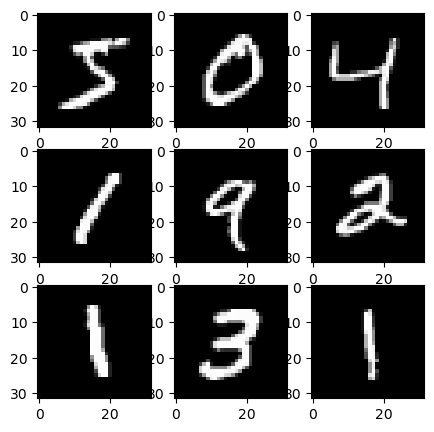

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i], cmap='gray')

## Principal Component Analysis (PCA)

In [20]:
# Flatten the inputs & normalization
X_train = X_train.reshape(X_train.shape[0], -1) / torch.max(X_train)
X_test = X_test.reshape(X_test.shape[0], -1) / torch.max(X_test)
print(X_train.shape)

torch.Size([60000, 1024])


In [21]:
from sklearn.decomposition import PCA

# keeping specific number of features
pca = PCA(n_components=256)
# fit
pca.fit(X_train)
# transform
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

(60000, 256) (10000, 256)


In [36]:
# keeping amount of variance
pca = PCA(n_components=0.99)
# fit
pca.fit(X_train)
# transform
X_train_pca = torch.tensor(pca.transform(X_train), dtype=torch.float)
X_test_pca = torch.tensor(pca.transform(X_test), dtype=torch.float)
print(X_train_pca.shape, X_test_pca.shape)

torch.Size([60000, 331]) torch.Size([10000, 331])


In [41]:
sum(pca.explained_variance_ratio_)

0.9900129424929288

## Dropout & L2

Use `nn.Dropout` layer:

During training, randomly zeroes some of the elements of the input tensor with probability p.

In [42]:
import torch.nn as nn


class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 100),
            nn.Dropout(p=0.1),
            nn.Sigmoid(),
            nn.Linear(100, 10),
            nn.Dropout(p=0.1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)



Set `weight_decay` to use L2 regularization.

$$\mathrm{Loss\_L2} = \mathrm{Loss} + \lambda\sum\theta_i^2 $$

In [43]:
model = NetDropout()
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

## Dataset & DataLoader

In [44]:
from torch.utils.data import Dataset, DataLoader


class MnistDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = MnistDataset(X_train, y_train)
test_data = MnistDataset(X_test, y_test)

In [45]:
len(train_data)

60000

In [46]:
train_data = MnistDataset(X_train_pca, y_train)
test_data = MnistDataset(X_test_pca, y_test)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [47]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([128, 331]) torch.Size([128])


## Trainer

In [48]:
import numpy as np
from tqdm import tqdm
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                # batch_importance is the ratio of batch_size 
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

{'train_loss_list': [1.953854073270164,
  1.6976252922058113,
  1.6583766642888382,
  1.6410647208531701,
  1.6318049741109202,
  1.6242043141682927,
  1.6194607844034818,
  1.6155706138610821,
  1.613178472391765,
  1.6106192827224728,
  1.6074101020812999,
  1.6059594261805212,
  1.603333020528158,
  1.6019683596293128,
  1.6007484980901092,
  1.5991668181737277,
  1.5979803078333548,
  1.5969474837621058,
  1.5956249532063802,
  1.5944269642511997,
  1.5939445273717245,
  1.5921851320266711,
  1.593940658060709,
  1.5914958676656084,
  1.5908963903427127,
  1.5906592164993283,
  1.5900011643091834,
  1.5890466676712023,
  1.5878049591700247,
  1.5873095454533899,
  1.5869221786499044,
  1.5855643744786592,
  1.5850921821594237,
  1.58522227935791,
  1.585398869132996,
  1.5846959139506027,
  1.585231760724385,
  1.584027119445801,
  1.5828676795323695,
  1.582756776682535,
  1.5826043802261356,
  1.5817362233479813,
  1.580856419881184,
  1.5816309234619157,
  1.5814246044794726,
  

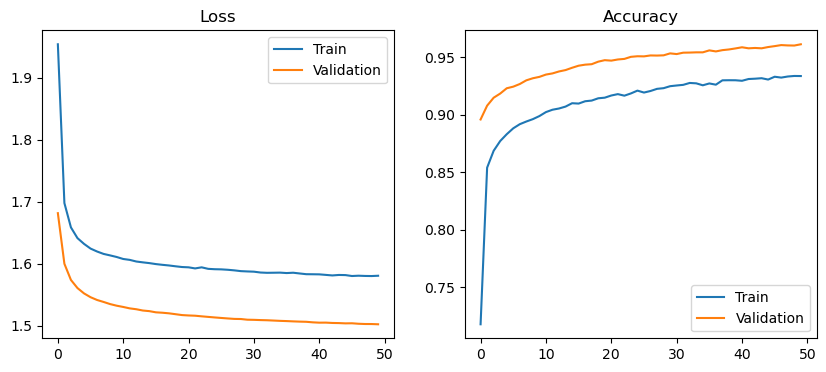

In [50]:
trainer = Trainer(model, "adam", 1e-3, 128, 50, 1e-5)
trainer.train(train_data, test_data)